## Auditing Use Case 1

In this notebook, we apply the auditing tool to the first use case: _Teaching recommendation: Economic activity (restricted to economically active only) aggregated by occupation and gender. Three way table taken from the teaching advice pages 11 \& 12_. We restrict the space to the three columns `X = (Economic Activity, Occupation, Sex)`, and want to audit a dataset card restricting the statistics to the pairwise marginals $m(X_1,X_2), m(X_2,X_3), m(X_1,X_3)$. This makes the auditing problem somewhat easier, as only the space $span(m(X_1,X_2,X_3))$ needs to be considered, which is relatively low dimensional.

We apply the methodology developed in notebook [v4] to a bunch of synthetic data generators:

- Honest IPF.
- Cheaty IPF.
- Honest MST.
- Cheaty MST.
- synthgauge (cheaty by default).

We first generate the vector space and basis (both of which are agnostic to the generator). We then 

In [1]:
import itertools
import numpy as np
import pandas as pd
import tqdm
import tqdm.notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loads of warnings coming from the sub-methods, which we don't care about.
import warnings
warnings.filterwarnings("ignore")

In [3]:
import auditing

### Parameters of the auditing

In [4]:
# How many times should records be duplicated in extremal datasets?
# The higher this number, the lower the sampling error, but the computational cost is linear in num_repeats.
num_repeats = 1000

In [5]:
# How many synthetic datasets should be generated for candidate selection?
# The error most likely decreases as sqrt(num_synthetic)^{-1}, but the computational cost is linear.
num_synthetic = 10

In [6]:
# Number of datasets to generate for the second step.
num_auditing_samples = 10

### Data
Load the data in a specific format.

In [7]:
columns = ['Economic Activity', 'Occupation', 'Sex']

In [8]:
df = pd.read_csv(
    '../../privacy-sdg-toolbox/examples/data/2011 Census Microdata Teaching File (original).csv',
)[columns].astype('category')

In [9]:
df.columns

Index(['Economic Activity', 'Occupation', 'Sex'], dtype='object')

In [10]:
for column in df.columns:
    df[column] = df[column].cat.codes

In [11]:
columns = list(df.columns)
num_columns = len(df.columns)
num_cat = df.max() + 1
num_cat_int = num_cat.values
num_cat_int

array([10, 10,  2], dtype=int8)

In [12]:
metadata = [
    {"name": column, "type": "finite", "representation": list(range(nc))}
    for column, nc in zip(df.columns, num_cat_int)
]

In [13]:
metadata

[{'name': 'Economic Activity',
  'type': 'finite',
  'representation': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
 {'name': 'Occupation',
  'type': 'finite',
  'representation': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
 {'name': 'Sex', 'type': 'finite', 'representation': [0, 1]}]

### Linear space

Define the vector space: $\phi$ is the set of all 2-way marginals.

In [14]:
def generate_kway_marginals(columns=None, k=1):
    columns = columns or range(len(num_cat_int))
    marginals = []
    for combs in itertools.combinations(columns, k):
        for values in itertools.product(*[range(num_cat_int[i]) for i in combs]):
            marginals.append(auditing.MarginalBin(combs, values))
    return marginals

In [15]:
phi = generate_kway_marginals(k=2)

In [16]:
len(phi)

140

In [17]:
# Write the scalar product for the whole space.
# scalar_product = auditing.NaiveScalarProduct(num_cat_int)
scalar_product = auditing.LinearCompositionScalarProduct(
    auditing.HistogramScalarProduct(num_cat)
)

In [18]:
# The linear space created by the known phis.
linspan_phi = auditing.OrthogonalSpace(scalar_product, phi)

In [19]:
len(linspan_phi.basis)

119

Define the candidate set $\mathcal{C}$ of all three-way marginal bins.

In [20]:
C = generate_kway_marginals(k=3)

In [21]:
C_perp = [linspan_phi.orthogonalise(b) for b in C]

Define the orthogonal space $span\left<\phi\right>^\perp$.

In [22]:
linspan_phi_perp = auditing.OrthogonalSpace(scalar_product, C_perp)

This defines the basis $(b_1, \dots, b_k)$ (linearly refactored for efficiency).

In [23]:
phi_perp_basis = [auditing.refactor_linear_combination(b) for b in linspan_phi_perp.basis]

In [24]:
k = len(phi_perp_basis)
k

81

Check that $dim(\text{span}\left<\phi\right>) + dim(\text{span}\left<\phi\right>^\perp) = dim(\mathcal{F})$.

In [25]:
assert len(linspan_phi.basis) + k == np.prod(num_cat_int), "Linear space not well defined!"

### Auditing toolkit

In [26]:
# All possible records.
unique_records = pd.DataFrame(list(itertools.product(*[range(nc) for nc in num_cat_int])), columns=columns)

In [27]:
beta = auditing.AddedFunctions(*phi_perp_basis)
beta = auditing.refactor_linear_combination(beta)

In [28]:
auditor = auditing.Auditor(phi, unique_records, len(unique_records), use_lp=False)

In [29]:
D_minus, D_plus = auditor.generate_extremal_datasets(beta, num_repeats=num_repeats)

This function selects a candidate function $g$, given a generator. It does the following:

1. Compute $\beta = \sum_{i=1}^k b_i$ and generate a pair of extremal datasets $D^-, D^+$ for $\beta$.
2. Generate synthetic datatsets from these extremal datasets, $D^{s-},D^{s+}$. 
3. Compute $\delta_i \triangleq \Delta^S b_i = b_i(D^{s-}) - b_i(D^{s+})$.
4. Estimate $g$ as $\hat{g} = \sum_{i=1}^k \frac{\delta_i}{\|\delta\|} b_i$.

Steps 2. and 3. can be repeated several times, and $\delta_i$ averaged over the runs, to reduce randomness.

In [100]:
# See notebook 8. for more details on this optimisation.

def compute_delta_optimised(D_synth_plus, D_synth_minus, phi_perp_basis):
    # Decompose each basis element in factors.
    factored_basis = []
    factors = set()
    for b in phi_perp_basis:
        lin_f = auditing.split_linear_combination(b)
        factored_basis.append(lin_f)
        # Add each factor in the basis to unique factors.
        for f in lin_f.keys():
            factors.add(f)
    # Compute the value of each factor over the datasets.
    # This is where the optimisation lies!
    factor_plus = {}
    factor_minus = {}
    for f in factors:
        factor_plus[f] = f(D_synth_plus).mean()
        factor_minus[f] = f(D_synth_minus).mean()
    # Finally, combine these answers.
    delta = []
    for b_factors in factored_basis:
        b_plus = 0
        b_minus = 0
        for f, a in b_factors.items():
            b_plus = b_plus + a * factor_plus[f]
            b_minus = b_minus + a * factor_minus[f]
        delta.append(b_plus - b_minus)
    return delta

In [101]:
def candidate_selection(generator, num_synth):
    deltas = []
    for repeat in tqdm.notebook.trange(num_synth):
        D_synth_minus = generator(D_minus)
        D_synth_plus = generator(D_plus)
#         delta = []
#         for b in phi_perp_basis:
#             delta.append(b(D_synth_plus).mean() - b(D_synth_minus).mean())
#         deltas.append(delta)
        deltas.append(compute_delta_optimised(D_synth_plus, D_synth_minus, phi_perp_basis))
    deltas = np.mean(deltas, axis=0)
    scale = deltas / np.linalg.norm(deltas)
    return auditing.refactor_linear_combination(
        auditing.AddedFunctions(*[s*b for s,b in zip(scale, phi_perp_basis)])
    )

In [19]:
def auditing_plot(results, color, label):
    x = []
    y = []
    df_r = pd.DataFrame(results, columns=('real', 'synth'))
    for real, subdf in df_r.groupby('real'):
        x.append(real)
        y.append(subdf.synth.values.mean())
    plt.plot(x, y, '*-', c=color, label=label)
    x, y = zip(*results)
    ix = np.argsort(x)
    plt.plot(np.array(x)[ix], np.array(y)[ix], '.', c=color, ms=10, alpha=.2)

Bring together the results.

In [32]:
def audit(generator, num_samples, label=''):
    g = candidate_selection(generator, num_synth=num_synthetic)
    results = auditor.audit(
        generator,
        g,
        num_samples=num_samples,
        num_repeats=num_repeats,
        iterator=tqdm.notebook.tqdm,
    )
    plt.figure(figsize=(7,7))
    auditing_plot(results, 'b', label)
    plt.xlabel("Value of $g(D_{input})$ for fixed $\\phi(D_{input})$", fontsize=15)
    plt.ylabel("Value of $g(D_{synthetic})$ generated from $D_{input}$", fontsize=15)
    plt.legend()
    return g, results

### Generators

In [33]:
from reprosyn.methods import IPF, MST, SYNTHPOP

2022-10-28 15:39:30.397147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [34]:
from mbi import Domain, Dataset, FactoredInference

In [35]:
old_metadata = [
    {"name": "Economic Activity", "type": "finite", "representation": ["5", "1", "-9", "4", "2", "6", "3", "9", "8", "7"]},
    {"name": "Occupation", "type": "finite", "representation": ["8", "6", "7", "1", "9", "-9", "5", "2", "3", "4"]},
    {"name": "Sex", "type": "finite", "representation": ["2", "1"]}
]

In [36]:
def generate_ipf(dataset, cheat = False):
    marginals = [(0, 1), (0, 2), (1, 2)]
    if cheat:
        marginals += [(0, 1, 2)]
    ipf = IPF(
        dataset=pd.DataFrame(dataset, columns=columns),
        metadata=metadata,
        size=len(dataset),
        marginals=marginals
    )
    ipf.run()
    return ipf.output.values

In [37]:
generate_ipf(unique_records);

100%|█████████████████████████████████████████████████| 200/200 [00:00<00:00, 11232.89it/s]


In [38]:
def generate_mst(dataset, cheat = False, sigma = 0.001):
    domain = Domain(columns, num_cat_int)
    dataset_mbi = Dataset(pd.DataFrame(dataset, columns=columns), domain)
    # Get measurements for 1-way histogram.
    marginals = [(0, 1), (0, 2), (1, 2)]
    if cheat:
        marginals += [(0, 1, 2)]
    marginals = [[columns[i] for i in m] for m in marginals]
    histograms = [dataset_mbi.project(m).datavector() for m in marginals]
    measurements = [(np.eye(h.size), h, sigma, m) for m, h in zip(marginals, histograms)]
    # Use the MBI procedure for the rest.
    engine = FactoredInference(domain, log=False)
    model = engine.estimate(measurements, engine='MD')
    synth = model.synthetic_data(rows=len(dataset))
    return synth.df.values

In [39]:
generate_mst(unique_records);

In [40]:
def generate_synthpop(dataset, cheat = False):
    model = SYNTHPOP(
        dataset=pd.DataFrame(dataset, columns=columns),
        metadata=metadata,
        size=len(dataset)
    )
    model.run()
    return model.output.values

In [41]:
generate_synthpop(unique_records);

train_Economic Activity
train_Occupation
train_Sex
generate_Economic Activity
generate_Occupation
generate_Sex


Grouping them together.

In [42]:
# List of method name, whether it cheats, and the function.

methods = [
    ("IPF-Honest", False, generate_ipf),
    ("IPF-Cheat", True, lambda data: generate_ipf(data, cheat=True)),
    ("MST-Honest", False, generate_mst),
    ("MST-Cheat", True, lambda data: generate_mst(data, cheat=True)),
    ("SynthPop", True, generate_synthpop)
]

Run.

In [43]:
results = []

In [ ]:
for name, cheat_flag, method in methods:
    print(f'====== {name} ======')
    results.append((audit(method, num_auditing_samples, name), name, cheat_flag))
    print('\n')

In [15]:
import pickle

In [99]:
with open('results-auditing-case1.pickle', 'wb') as ff:
    pickle.dump(results, ff)

## Results

In [16]:
with open('results-auditing-case1.pickle', 'rb') as ff:
    results = pickle.load(ff)

### Figure for the differences

In [17]:
renaming = {
    "IPF-Honest": "IPF (Honest)",
    "IPF-Cheat": "IPF (Dishonest)",
    "MST-Honest": "MST (Honest)",
    "MST-Cheat": "MST (Dishonest)",
    "SynthPop": "SynthPop"
}

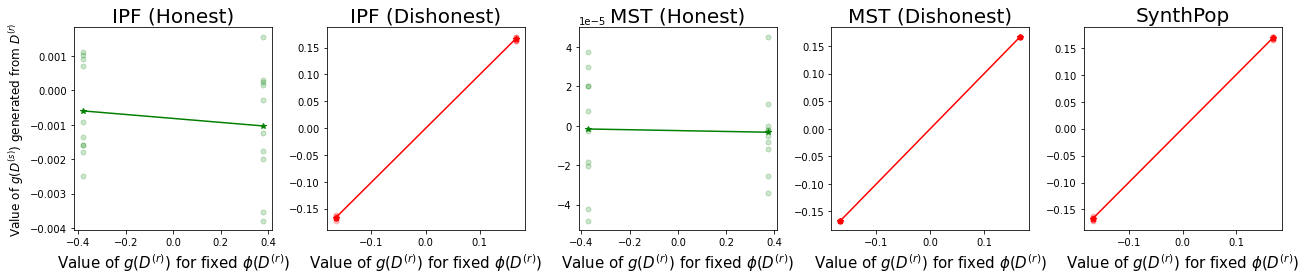

In [20]:
plt.figure(figsize=(18, 4))

i = 1
for r, name, cheat_flag in results:
    plt.subplot(1, len(results), i)
    auditing_plot(r[1], 'r' if cheat_flag else 'g', name)
    plt.xlabel("Value of $g(D^{(r)})$ for fixed $\\phi(D^{(r)})$", fontsize=15)
    if i==1:
        plt.ylabel("Value of $g(D^{(s)})$ generated from $D^{(r)}$", fontsize=12)
    plt.title(renaming[name], fontsize=20)
    i += 1

plt.tight_layout()
plt.savefig("auditing_usecase1.pdf");

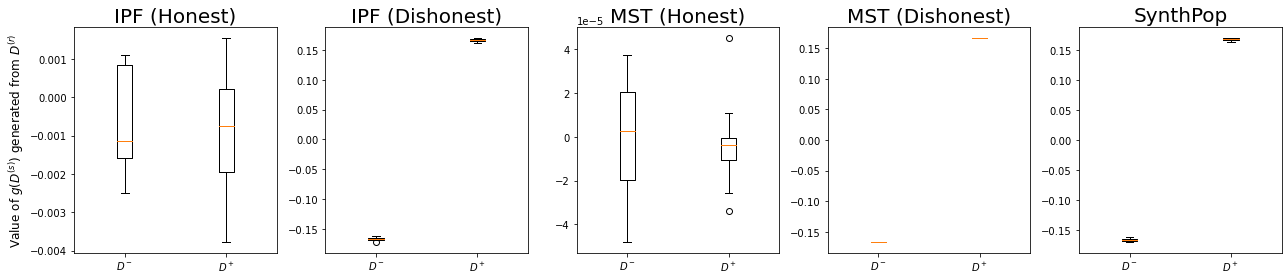

In [21]:
def better_plot(results, color, label):
    x = []
    y = []
    df_r = pd.DataFrame(results, columns=('real', 'synth'))
    for real, subdf in df_r.groupby('real'):
        x.append(real)
        y.append(subdf.synth.values)
#     plt.boxplot(y, labels=[f"{i:.2f}" for i in x])
    plt.boxplot(y, labels=["$D^-$", "$D^+$"])

plt.figure(figsize=(18, 4))

i = 1
for r, name, cheat_flag in results:
    plt.subplot(1, len(results), i)
    better_plot(r[1], 'r' if cheat_flag else 'g', name)
#     plt.xlabel("Value of $g(D^{(r)})$ for fixed $\\phi(D^{(r)})$", fontsize=15)
    if i==1:
        plt.ylabel("Value of $g(D^{(s)})$ generated from $D^{(r)}$", fontsize=12)
    plt.title(renaming[name], fontsize=20)
    i += 1

plt.tight_layout()
plt.savefig("auditing_usecase1.pdf");

### Statistical test

In [18]:
from scipy.stats import ttest_ind

In [19]:
for r, name, cheat_flag in results:
    x = [x[1] for x in r[1]]
    t_test_result = ttest_ind(x[:num_auditing_samples], x[num_auditing_samples:])
    print(f"{name} -- [{cheat_flag}]", '\t', t_test_result.pvalue)

IPF-Honest -- [False] 	 0.5437285529660334
IPF-Cheat -- [True] 	 8.89232374080767e-34
MST-Honest -- [False] 	 0.8891974313684998
MST-Cheat -- [True] 	 5.387514743396163e-66
SynthPop -- [True] 	 5.135584005278585e-35
